# Rob Ross : Discovering Colors Through Happy Little Accidents


This notebook runs through the *autonomous* color matching demo performed using a **Jubilee** platform, equipped with an Opentrons OT-2 Pipette and a Raspberry Pi Camera V3 interfaced as a WebCamera tool. 
Both of these tools are outlined and defined in the `Science_Jubilee/tool_library` section of the [repository](https://github.com/machineagency/science_jubilee)
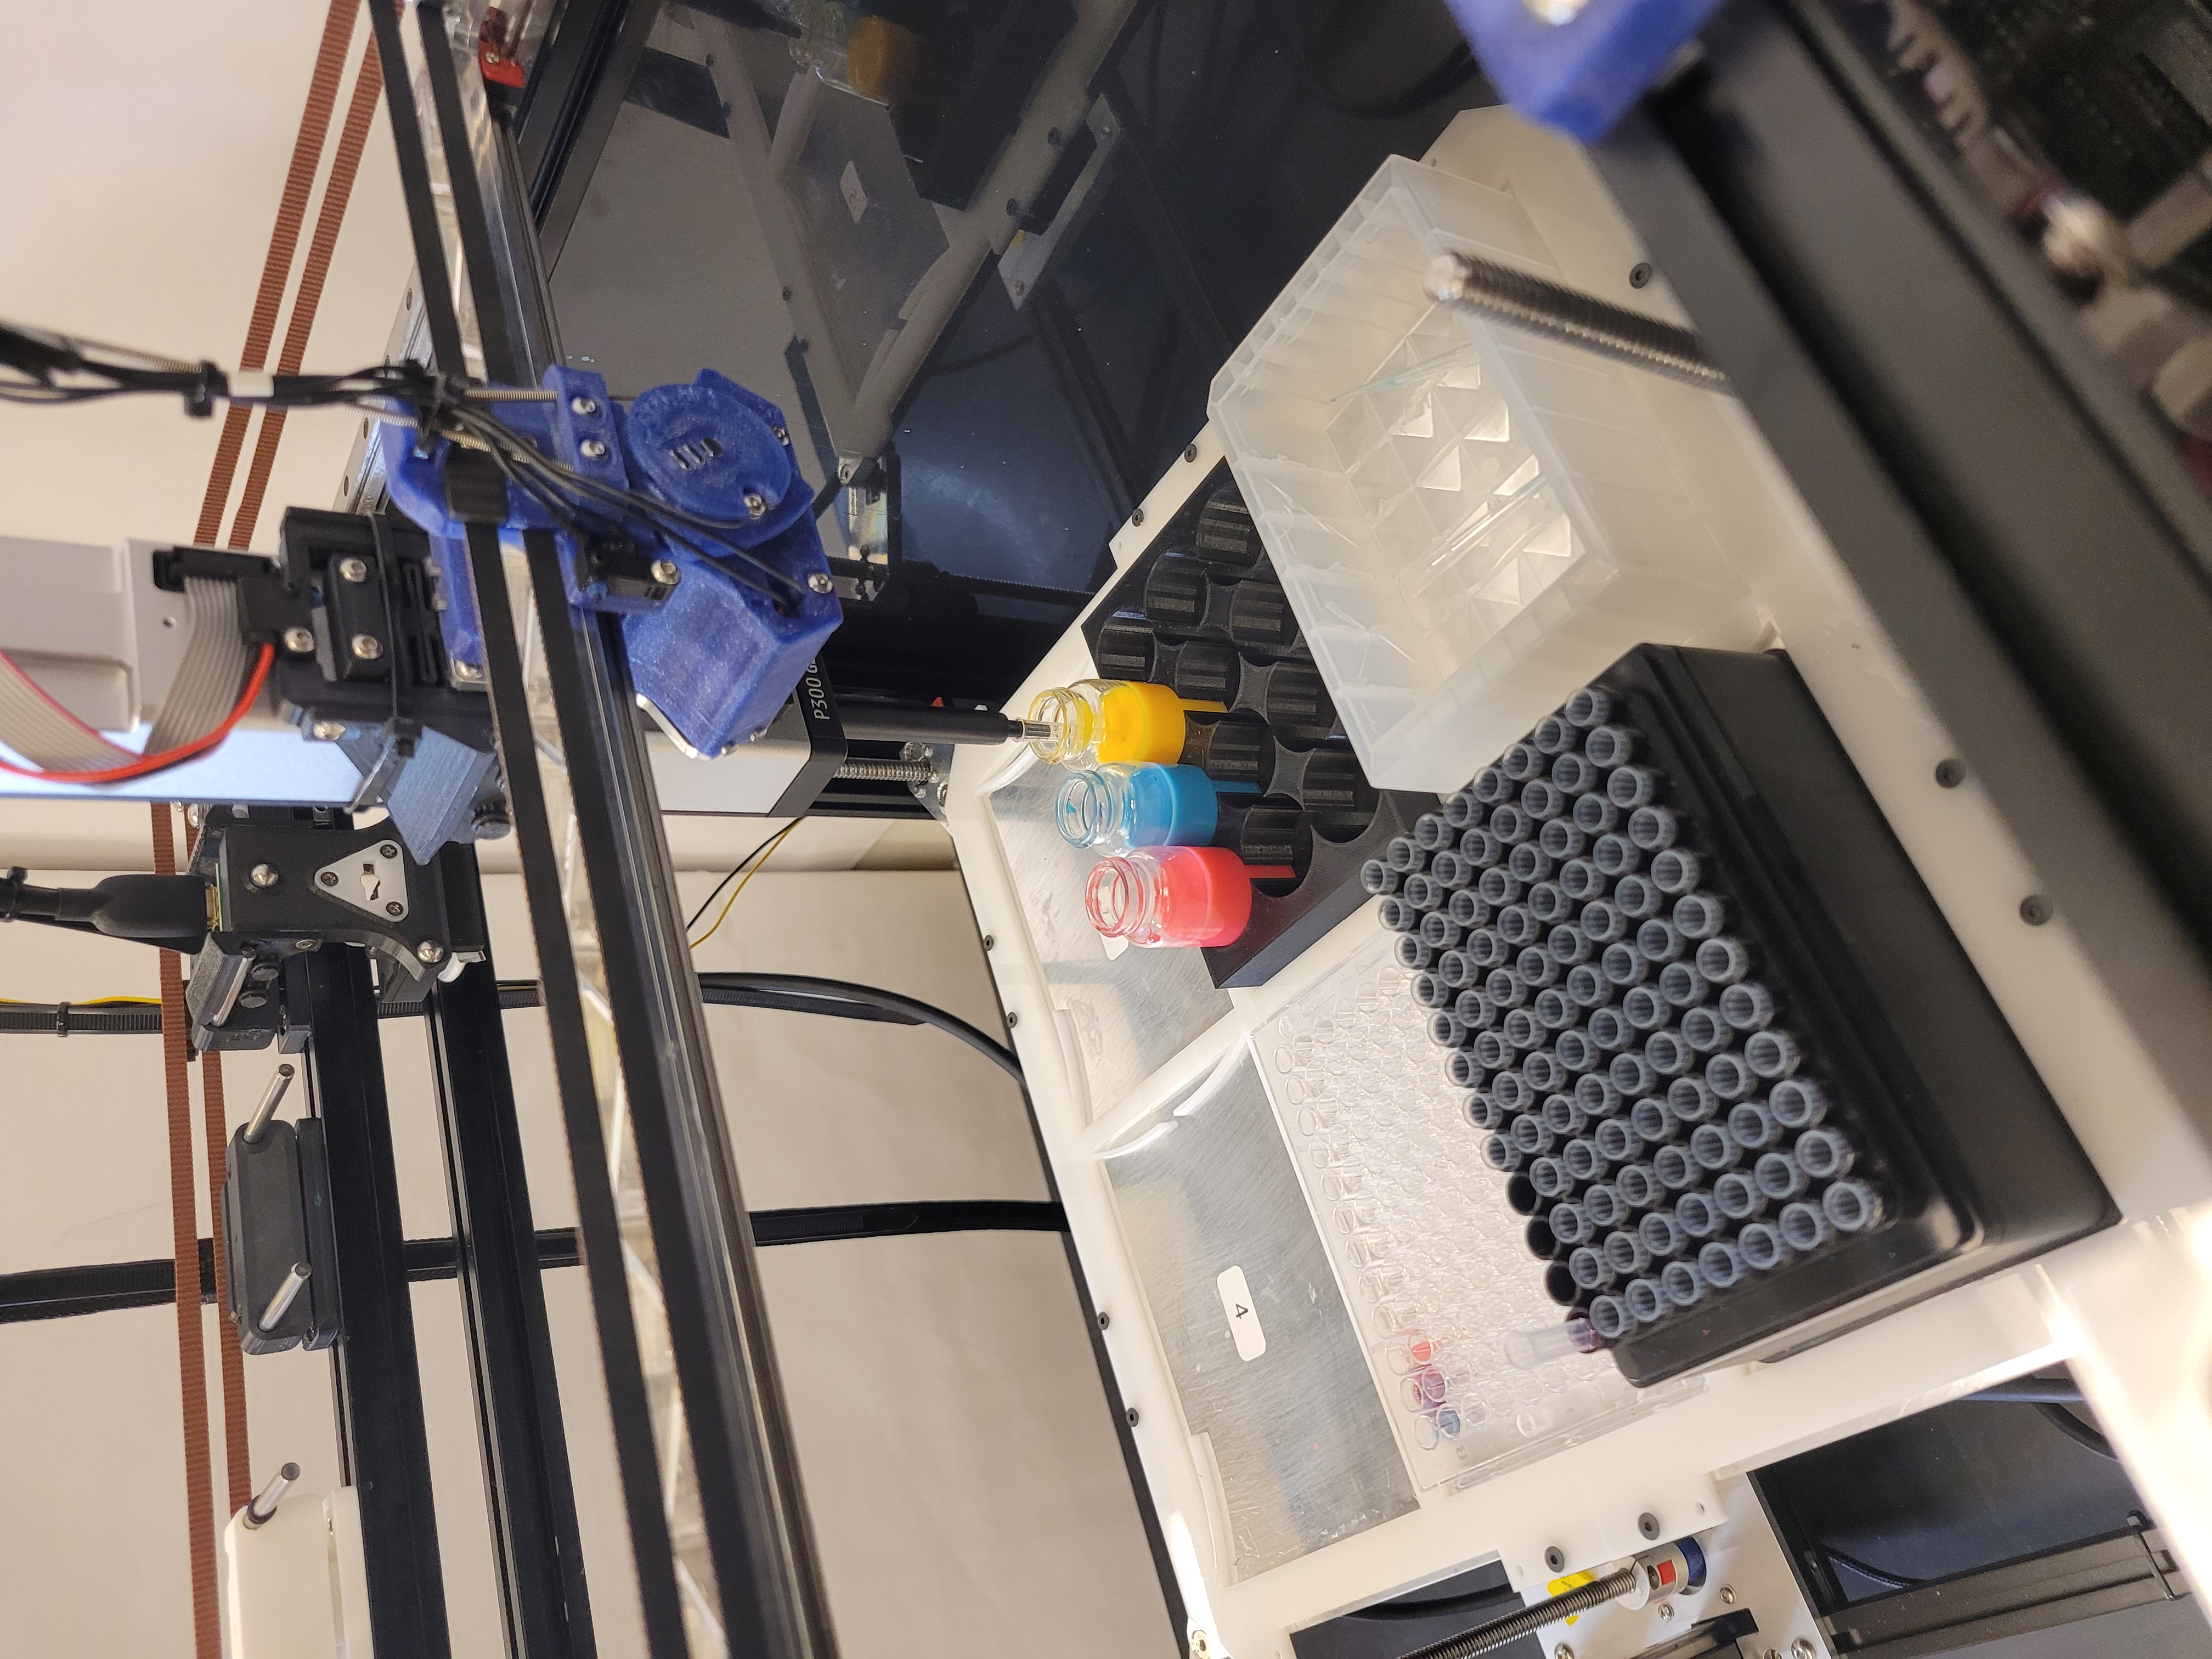

#### Necessary Imports 

As usual, let's start by importing the necessary packages we will need to run our demo.

In this case, we will also set up our matplotlib- the package we will use to visualize the beautiful art that our Rob Ross will generate as an external window.

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
# ----------- Science Jubilee -------------
from science_jubilee import Machine as Jub
from science_jubilee.tools import Pipette, WebCamera

# --------- Color Matching Demo -----------
from jubilee_pipette_bodemo.color_matcher import ColorMatcher

# ------ Data visualization outside of the notebook ------
import matplotlib
#matplotlib.use('Qt5Agg')

### Jubilee platfform connection and set-up

In [4]:
jubilee = Jub.Machine(address='192.168.1.2', simulated = False) 

Before we can set up the `deck` of our `Jubilee` with all our labware, we will need to *home* **all** its axis.

> Attention -- !!! **BEFORE** !!! running the next cell, make sure that NO labware is loaded onto the deck or the Tool Changer will crush into them. 

In [4]:
jubilee.home_all()

### Deck preparation and labware definition 
Awesome, now that we have our machine all ready to go, we will need to load all the labware onto it both *physically* and *digitally* . 

* Physically: place the desired/required labware for the Demo onto the deck of your Jubilee
* Digitally: first, we need to define our `deck`; then define and load the `labware` we want to use and indicate on which `slot` each of them was assigned to

In [5]:
# ---------------- Deck -------------------
deck = jubilee.load_deck('lab_automation_deck.json')

To run this *autonoous* color matching demo, we will need at least four types of labware:

* A **Tiprack** that is suitable for the pipette you are using to transfer your liquids
* A **Sample Labware** that will be used to collect the colors that your Rob Ross will make 
* A **Stock Labware** that will host the stock colors that your Rob Ross can mix together
* A **trash** to collect the used tips

In [6]:
# -------------- Labware ------------------
tiprack = jubilee.load_labware('opentrons_96_tiprack_300ul.json', 0)
tiprack.load_manualOffset()
samples = jubilee.load_labware('fisherbrand_96_wellplate_360ul.json', 2)
samples.load_manualOffset()
stocks = jubilee.load_labware('20mlscintillation_12_wellplate_18000ul.json', 3)
trash = jubilee.load_labware('agilent_1_reservoir_290ml.json', 1)

New manual offset applied to opentrons_96_tiprack_300ul
New manual offset applied to fisherbrand_96_wellplate_360ul


In [7]:
UL = (27.6, 175.2)
UR = (126.6, 175.2)
BR = (126.6, 112.8)
samples.manual_offset((UL, UR, BR))

UL = (28.4, 78.8)
UR = (127.5, 78.8)
BR = (127.5, 43.4)
tiprack.manual_offset((UL, UR, BR))

New manual offset applied to fisherbrand_96_wellplate_360ul
New manual offset applied to opentrons_96_tiprack_300ul


You can notice that the *tiprack* and the *samples* labware have a `manualOffset()` applied to them. This is to ensure that the labware coordinates are as precise as we can. The manual offset is **labware** and **slot** dependent, so you will need to run it prior to do so. You can find more information on how to run this in the `Science Jubilee` repository/documentation

This next 

In [9]:
# ------------- Stocks ------------
red_stock = stocks[0].bottom(+5)
yellow_stock = stocks[1].bottom(+5)
blue_stock = stocks[2].bottom(+5)
black_stock = stocks[3].bottom(+5)
white_stock = stocks[4].bottom(+5)

color_stocks = [red_stock, yellow_stock, blue_stock, black_stock, white_stock]

In [10]:
tiprack.manualOffset

{'0': ((28.4, 78.8), (127.5, 78.8), (127.5, 43.4))}

### Tool import and set up

Once again we will need to load all our tools onto our machine both *physically* and *digitally* . 

To learn how to load the tools *physically*, you can find more information and resources in the `Science_Jubilee` [documentation](https://machineagency.github.io/science_jubilee/building/building_tools.html#building-tools)

Each tool will at minimum require a `tool_index`, an integer, and a `tool_name`. These should be the same as the ones defined in the machine's `config.g` file. 
Some tools will also required further information. You can defined these individually or in a config file for easier tool load. 

**Pipette Tool**

In [11]:
P300 = Pipette.Pipette.from_config(1, 'Pipette', 'P300_config.json')
jubilee.load_tool(P300)

Even though you will be able to use te pipette after these two single lines, you can also associate its `tiprack` to the tool, as well as define a `trash` location. This will just make the code more clean.

In [12]:
P300.add_tiprack(tiprack)
P300.trash = trash[0]

**Camera Tool**

In [13]:
#Camera Tool
Camera = WebCamera.Camera.from_config(0, 'Camera', 'WebCamera_config.json')
jubilee.load_tool(Camera)

## Let's define the optimizer agent and run the campaign

A lot of the code is hidden in the background for a cleanier notebook, but the structure of our `ColorMatcher` optimizer is relatively simple. To define our ColorMatcher class we will need to indicate:

* The number of color stocks we will use areour inputs. These can vary as you might choose to use RED, YELLOW, and BLUE, or add BLACK, or even confuse your Optimizer and give other colors stocks, jsut to see if it can actually learn 
* The total sample volue, this allows you to use different labware for your sample collection
* The type of score you want to use. In this case, there are two score implemented, a simple `euclidean` score, and also the `CIE200` which is a "color math" which uses the L\*a\*b space instead of RGB

Behind the scene, the code is made up of 2 different components:
1. A simple Bayesian Optimizer is initialized as our autonomous agent. This uses a `Gausian Process Regressor` as a model, an `Expected Improvement` as the acquisition function and a `Stochastic Sampler` for sampling your learned space. 
2. A module used for comunicating with `Jubilee`, this will use the `Pipette` tool to distribute and mix together the inidcated volumes of your color stocks (our inputs), then the `Camera` tool will capture an image of the sample. Using some simple image processing, a circle with radius 50 pixels will be drawn over the well and the average of these pixel values to obtaine an `[R,G,B]` value, used for scoring how close the current sample is to your target. 

The result from step 2, will be fed into the optimizer (1) and then repeated for a total of `n` iterations, or until a perfect match is found.

In [16]:
RobRoss = ColorMatcher(5, sample_volume=300, score_type='euclidean', task = 'minimize', n_random_its=3, n_bo_its=10, in_silico_mixing=False, http_url='http://localhost:5000')

Before we can proceed with the campaing, we need to define what target color we want our `RobRoss` to make. Run the next cell and select a color from the color widget. Once you are done select, you can continue to the next step, the value is saved already in your class!

In [17]:
target_color = RobRoss.select_target_color()

ColorPicker(value='blue', description='Pick a color')

## Run the Color Matching campaign

We are almost ready to go. The last thing we need to do is decide how many samples we would like to allow our `Rob Ross` to run. Then we can just pass a few inpust to our initialize our class method as follows:

`run_campaign( n_iterations, jubilee_machine, pipette, camera, list_of_stocs, sample_labware, starting_well, save_campaign_results [T/F])`

Dispensing into well Well A1 form Fisherbrand 96 Well Plate 360 ÂµL on slot 2
http optimizer is asking service for next trial experiment 161106631563263564650439343614863707935
new trial index:  0
query point:  [0.0019571857906650865, 1.6795939757197374e-05, 0.2451927341608831, 0.5886659492435821, 0.16416733486511256]
type query pt:  <class 'list'>
RYB values tested: [0.0019571857906650865, 1.6795939757197374e-05, 0.2451927341608831, 0.5886659492435821, 0.16416733486511256]
corrected volumes:  [0, 0, 73.55782024826493, 176.59978477307462, 49.25020045953377]
Calculated volumes:  [0, 0, 73.55782024826493, 176.59978477307462, 49.25020045953377]
RGB values observed: [57.721375398794756, 50.676011355571326, 50.78388928317956]
color score:  [1.0376436394264141]
type:  <class 'list'>
Updating optimizer for experiment 161106631563263564650439343614863707935
Dispensing into well Well A2 form Fisherbrand 96 Well Plate 360 ÂµL on slot 2
http optimizer is asking service for next trial experiment 1

AssertionError: Error when updating trial, b''

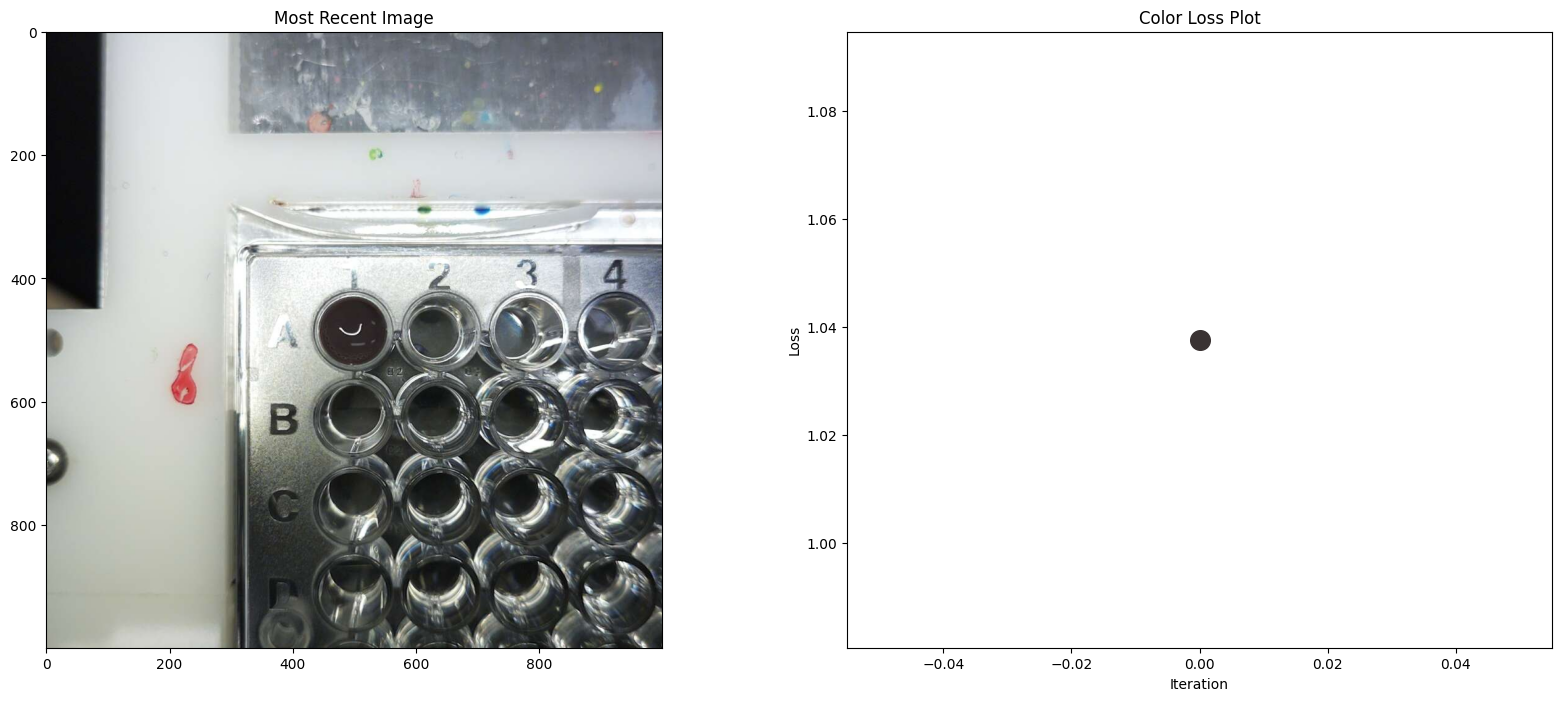

In [18]:
RobRoss.run_campaign(13,jubilee, P300, Camera, color_stocks, samples, starting_well = 0 ,save =True)

In [13]:
RobRoss.optimizer.uuid

'226408044774112031107895032385624503554'

In [14]:
import requests


In [16]:
r = requests.get('http://localhost:5000/get_open_experiment')

In [17]:
r.json()

{'uuid': None}